In [42]:
from pca_invest import loadData, Strategy

data = loadData(data_path="data/daily_ret_clean.csv")

strat = Strategy(pca_components=5)
strat.trainWeights(data[:int(len(data)*0.6)])

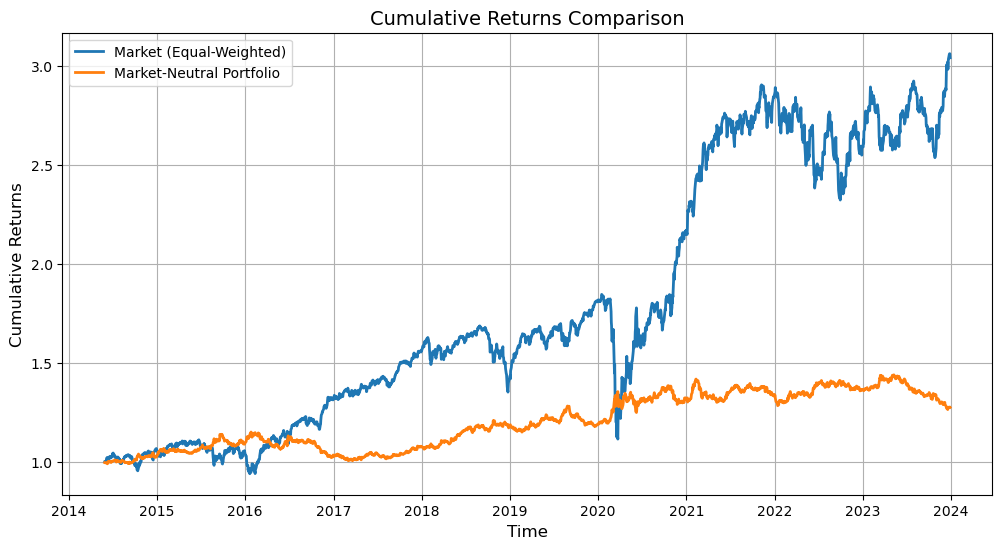

{'Daily Sharpe': 0.02350295979401817,
 'Annualized Sharpe': 0.4645311077048652,
 'Daily Information': -0.08620997703880523,
 'Annualized Information': -1.7929667100362943}

In [43]:
strat.testWeights(data[int(len(data)*0.6):])

# Part 11
Note that you have estimated the PCA using the entire sample. Thus, your estimates of
your trading performance should be somewhat positively biased. Now, repeat your exercise,
where you simulate a trading strategy across time, where you:
(a) Estimate your factors only based on data in the past (so at 2015 January, you construct
your PCAs using data up to 2015 January).
(b) Construct a trading strategy, and see how this strategy performs.
A simple starting point is to estimate αi’s using data prior to 2015, and assume αi’s stay
fixed afterwards. Of course, you can also update your αi estimates every day/month when
you roll forward. Be very clear how you avoided the look-ahead bias.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def time_series_cross_validation(data, start_date='2015-01-01'):
    """
    Avoiding look-ahead bias
    
    Parameters:
    - data: DataFrame of returns
    - start_date: Date to start the out-of-sample testing
    
    Returns:
    - dictionary containing strategy performance metrics
    """
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
    
    train_data = data[data.index < start_date]
    test_data = data[data.index >= start_date]
    
    strategy_returns = []
    market_returns = []
    timestamps = []
    
    initial_strategy = Strategy(pca_components=5)
    initial_strategy.trainWeights(train_data)
    
    initial_weights = initial_strategy.weights.copy()
    
    for i in range(len(test_data)):
        current_date = test_data.index[i]
        current_returns = test_data.iloc[i]
        
        strategy_return = (initial_weights * current_returns).sum()
        market_return = current_returns.mean()
        
        strategy_returns.append(strategy_return)
        market_returns.append(market_return)
        timestamps.append(current_date)
    

    
    performance = calculate_performance(strategy_returns, market_returns)
    
    plot_strategy_performance(strategy_returns, market_returns, timestamps)
    
    return {
        'strategy_returns': pd.Series(strategy_returns, index=timestamps),
        'market_returns': pd.Series(market_returns, index=timestamps),
        'performance': performance,
        'initial_weights': initial_weights
    }

def calculate_performance(strategy_returns, market_returns):
    """
    Helper to calculate performance metrics
    """
    strategy_returns = pd.Series(strategy_returns)
    market_returns = pd.Series(market_returns)
    
    strat_cumulative = (1 + strategy_returns).cumprod()
    market_cumulative = (1 + market_returns).cumprod()
    
    return {
        'Cumulative Return': strat_cumulative.iloc[-1] - 1,
        'Sharpe Ratio': strategy_returns.mean() / strategy_returns.std() * np.sqrt(252),
        'Outperformance': strat_cumulative.iloc[-1] / market_cumulative.iloc[-1] - 1,
        'Max Drawdown': calculate_max_drawdown(strat_cumulative)
    }

def calculate_max_drawdown(cumulative_returns):
    """
    Adding support for max_drawdown statistic
    """
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def plot_strategy_performance(strategy_returns, market_returns, timestamps):
    """
    Visualization tools
    """
    plt.figure(figsize=(12, 8))
    
    # Cumulative returns
    strat_cumulative = (1 + pd.Series(strategy_returns, index=timestamps)).cumprod()
    market_cumulative = (1 + pd.Series(market_returns, index=timestamps)).cumprod()
    
    plt.plot(strat_cumulative.index, strat_cumulative.values, label='Strategy', linewidth=2)
    plt.plot(market_cumulative.index, market_cumulative.values, label='Market', linewidth=2)
    
    plt.title('Cumulative Returns: Strategy vs Market', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

def run_look_ahead_bias_analysis(data, start_date='2015-01-01'):
    """
    Core program for look-ahead bias analysis
    """
    results = time_series_cross_validation(data, start_date)
    
    print("\nStrategy Performance Metrics:")
    for metric, value in results['performance'].items():
        print(f"{metric}: {value}")
    
    return results

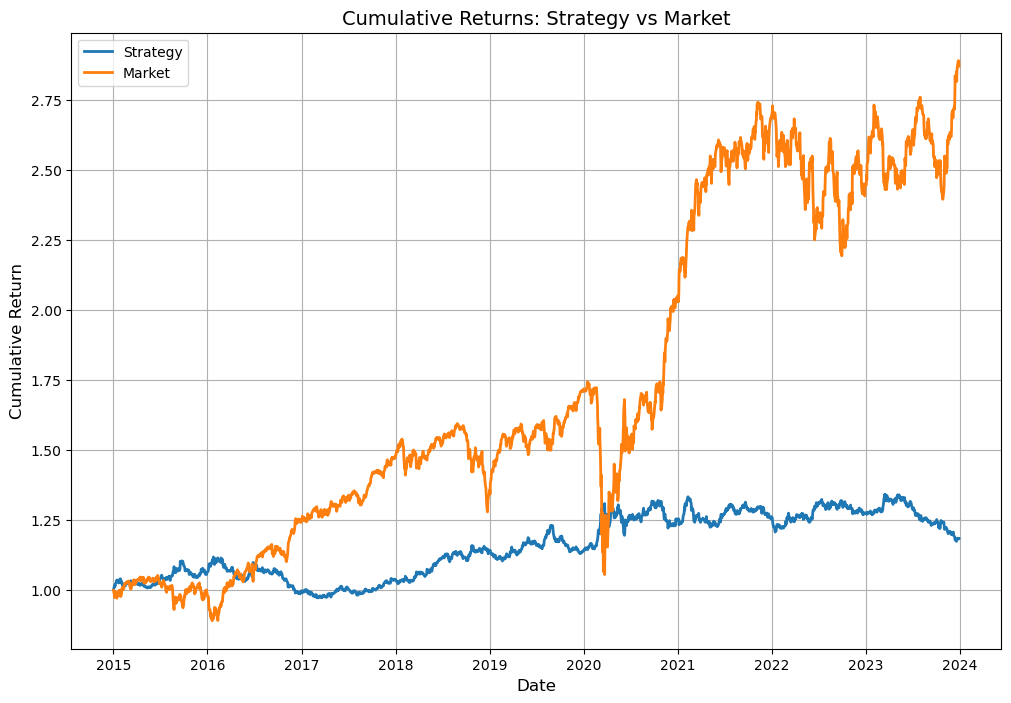


Strategy Performance Metrics:
Cumulative Return: 0.18196985703655177
Sharpe Ratio: 0.2720438792987717
Outperformance: -0.5881579225429958
Max Drawdown: -0.13099417358010476


{'strategy_returns': 2015-01-02   -0.000723
 2015-01-05    0.012100
 2015-01-06    0.004927
 2015-01-07   -0.000946
 2015-01-08   -0.003386
                 ...   
 2023-12-22    0.002500
 2023-12-26    0.000088
 2023-12-27   -0.000702
 2023-12-28   -0.001453
 2023-12-29    0.001120
 Length: 2264, dtype: float64,
 'market_returns': 2015-01-02   -0.002817
 2015-01-05   -0.014523
 2015-01-06   -0.011057
 2015-01-07    0.009122
 2015-01-08    0.013607
                 ...   
 2023-12-22    0.005103
 2023-12-26    0.008332
 2023-12-27    0.000300
 2023-12-28   -0.000096
 2023-12-29   -0.006527
 Length: 2264, dtype: float64,
 'performance': {'Cumulative Return': 0.18196985703655177,
  'Sharpe Ratio': 0.2720438792987717,
  'Outperformance': -0.5881579225429958,
  'Max Drawdown': -0.13099417358010476},
 'initial_weights': 10026    0.001580
 10032    0.000680
 10044    0.002693
 10065   -0.002892
 10104   -0.000491
            ...   
 90983    0.002431
 91287    0.002639
 91556    0.002419
 92

In [45]:
run_look_ahead_bias_analysis(data, start_date='2015-01-01')

### Part 12
Why stop at K = 5? Across multiple values of K, re-do all of the above exercises. Which
K seems to work best? Is there a significant difference between in-sample assessments (one
where you estimate the factors based on all the data) and out-sample assessments (one where
you estimate the factors only based on data available at the time and roll forward)? Discuss.

In [ ]:
def analyze_pca_components(data, k_values, start_date='2015-01-01'):
    """
    Parameters:
    - data: DataFrame of returns
    - k_values: List of PCA component values (e.g., [1, 2, 3, ..., 10])
    - start_date: Date to start the out-of-sample testing

    Returns:
    - results for in-sample and out-of-sample performance metrics
    """
    in_sample_results = {}
    out_of_sample_results = {}

    for k in k_values:
        print(f"\nAnalyzing PCA Components: K = {k}")
        
        strat = Strategy(pca_components=k)

        train_data = data[data.index < start_date]
        test_data = data[data.index >= start_date]

        # Split in/out-of-sample data
        strat.trainWeights(train_data)
        in_sample_metrics = strat.testWeights(train_data, plot=False)
        in_sample_results[k] = in_sample_metrics

        out_of_sample_metrics = time_series_cross_validation(data, start_date)
        out_of_sample_results[k] = out_of_sample_metrics['performance']

    return in_sample_results, out_of_sample_results


def plot_results(in_sample_results, out_of_sample_results):
    """
    Visualize the performance metrics for in-sample and out-of-sample assessments
    """
    k_values = list(in_sample_results.keys())
    
    in_sample_sharpe = [res["Annualized Sharpe"] for res in in_sample_results.values()]
    out_of_sample_sharpe = [res["Sharpe Ratio"] for res in out_of_sample_results.values()]
    
    plt.figure(figsize=(12, 6))
    plt.plot(k_values, in_sample_sharpe, label="In-Sample Sharpe Ratio", marker="o")
    plt.plot(k_values, out_of_sample_sharpe, label="Out-of-Sample Sharpe Ratio", marker="o")
    plt.title("Sharpe Ratio Across PCA Components (K)", fontsize=14)
    plt.xlabel("Number of PCA Components (K)", fontsize=12)
    plt.ylabel("Sharpe Ratio", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()
    



Analyzing PCA Components: K = 1


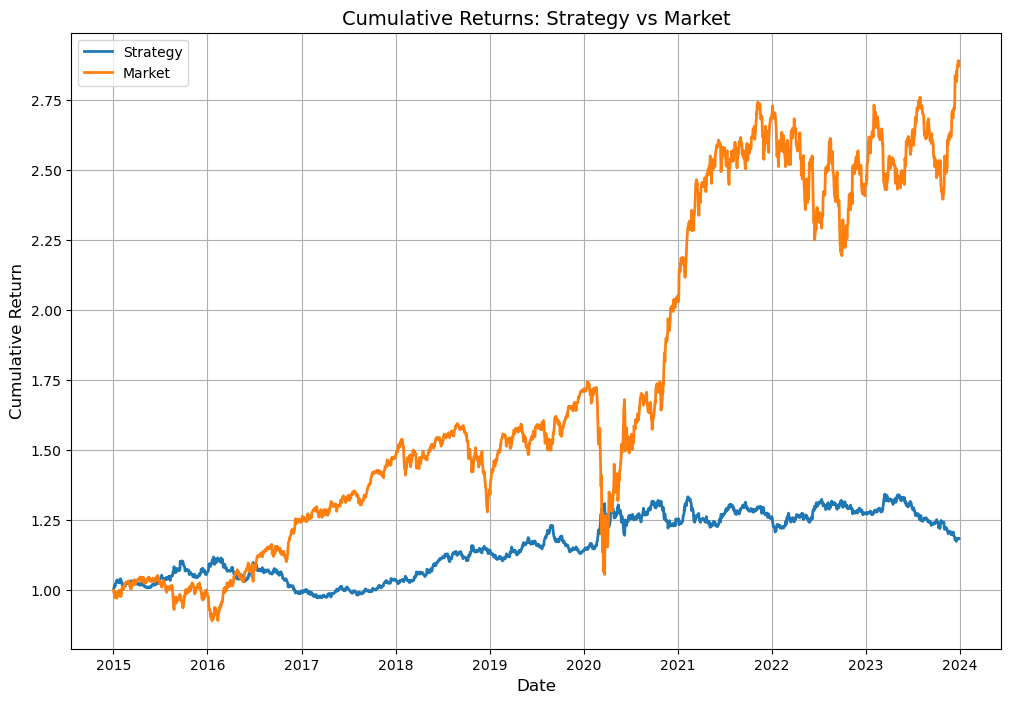


Analyzing PCA Components: K = 2


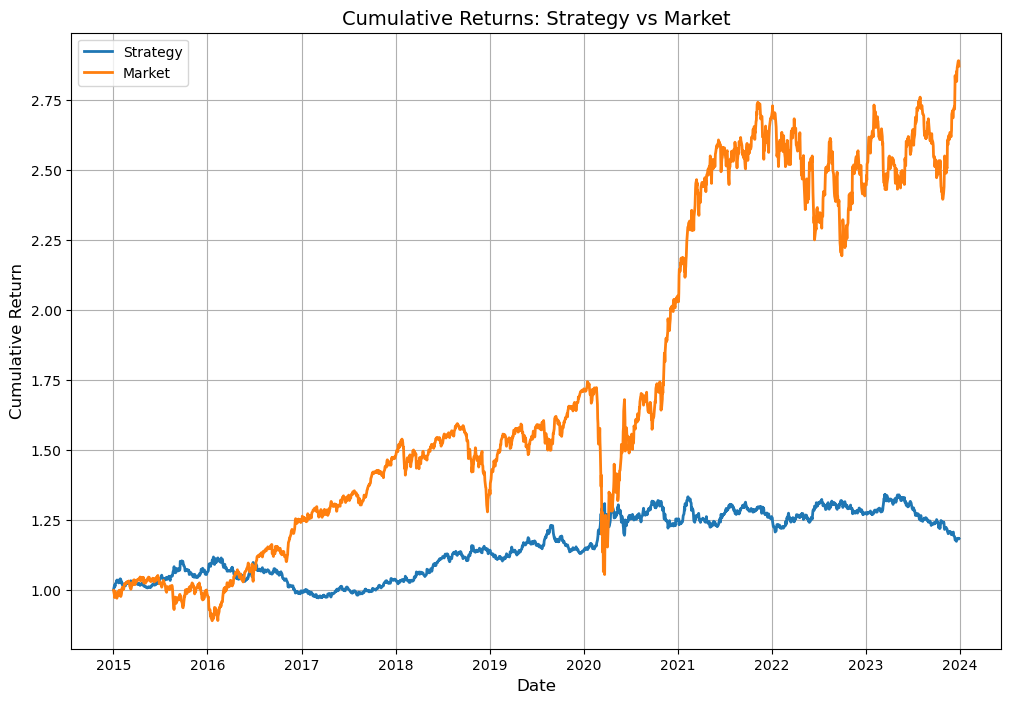


Analyzing PCA Components: K = 3


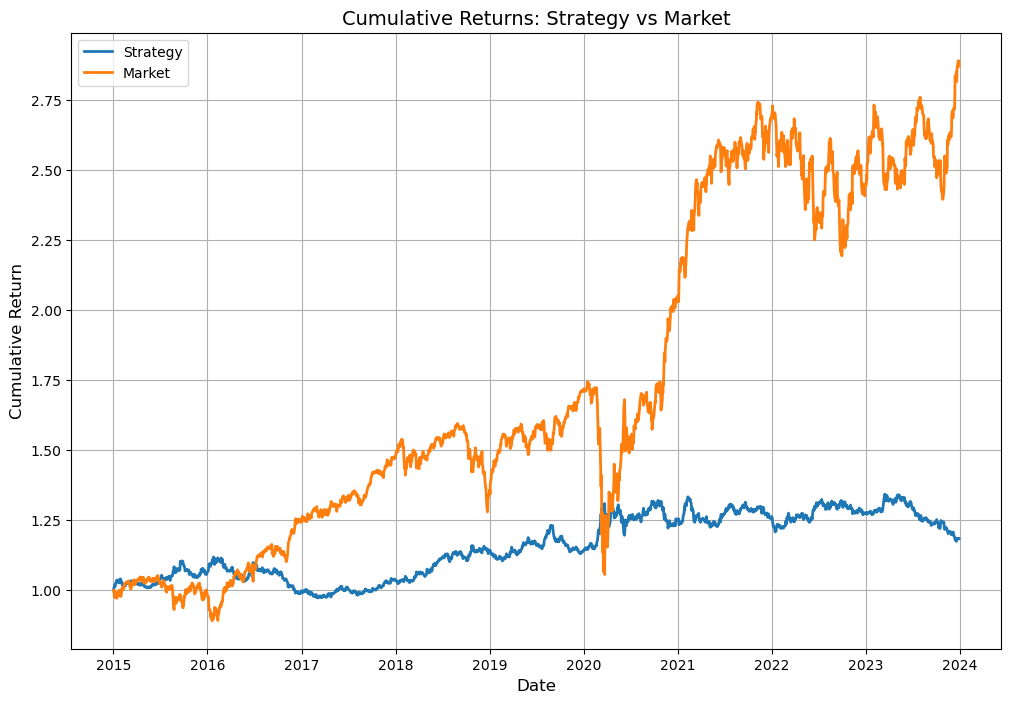


Analyzing PCA Components: K = 4


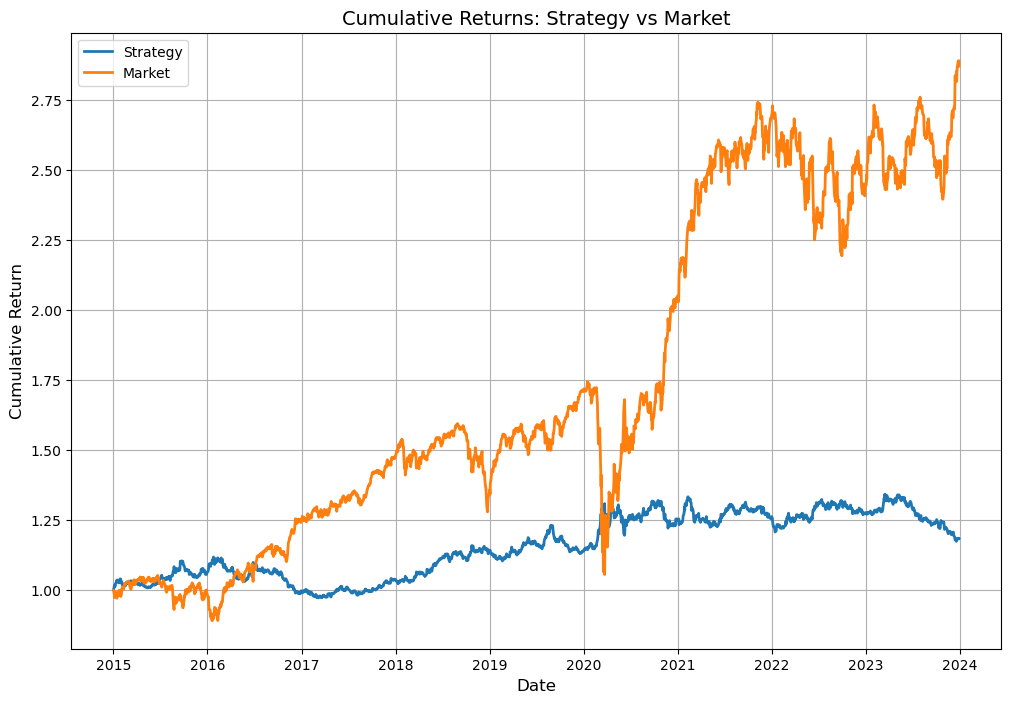


Analyzing PCA Components: K = 5


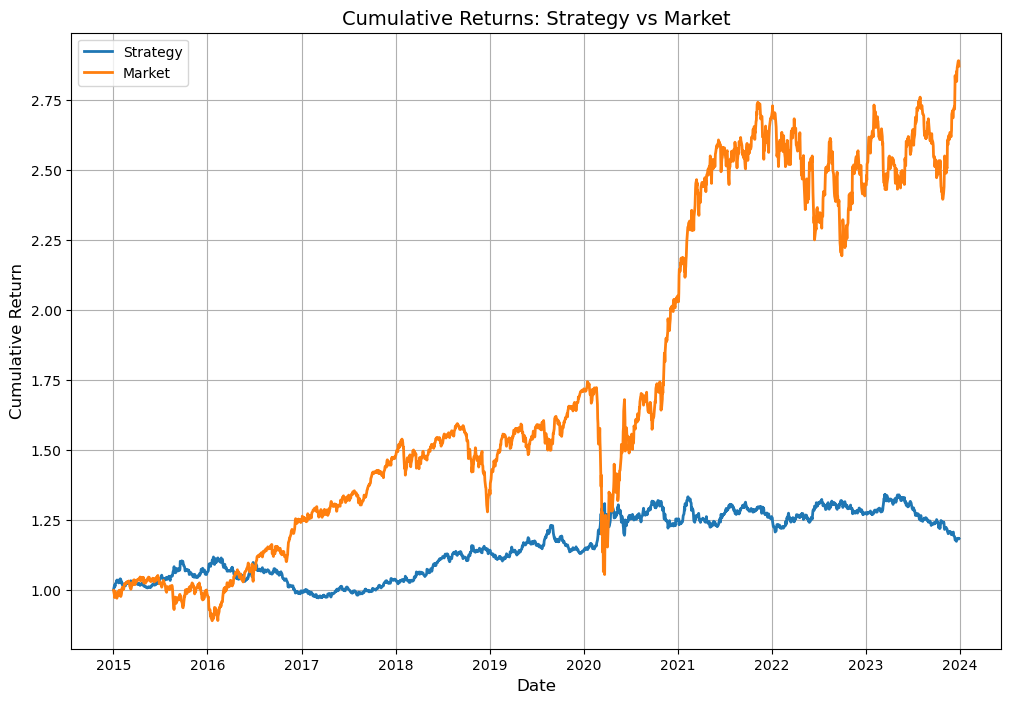


Analyzing PCA Components: K = 6


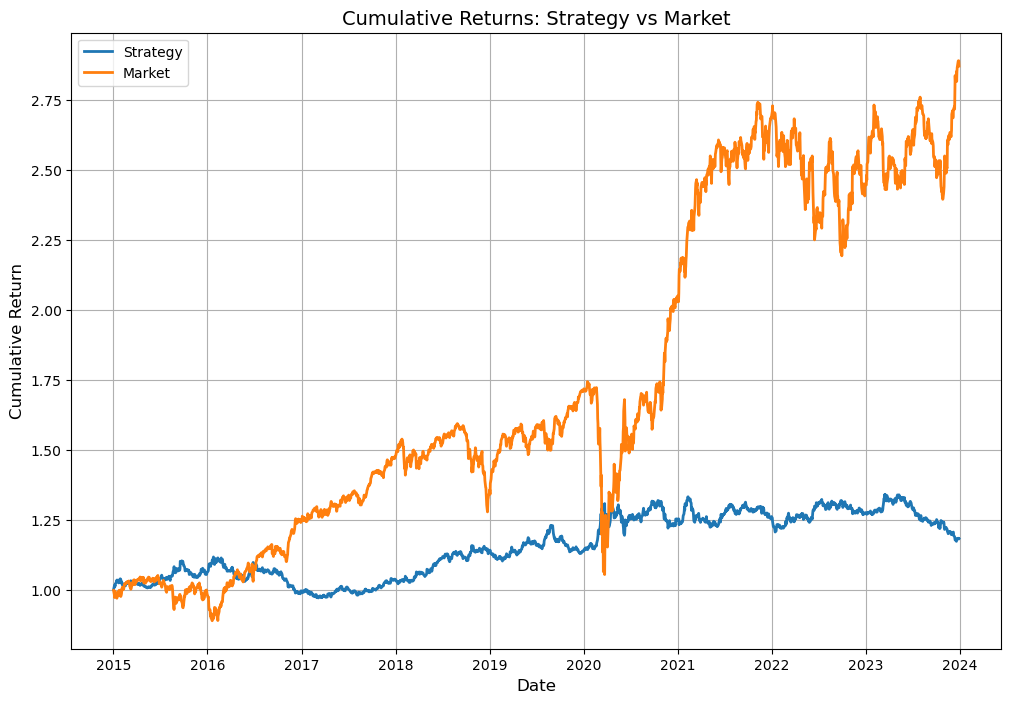


Analyzing PCA Components: K = 7


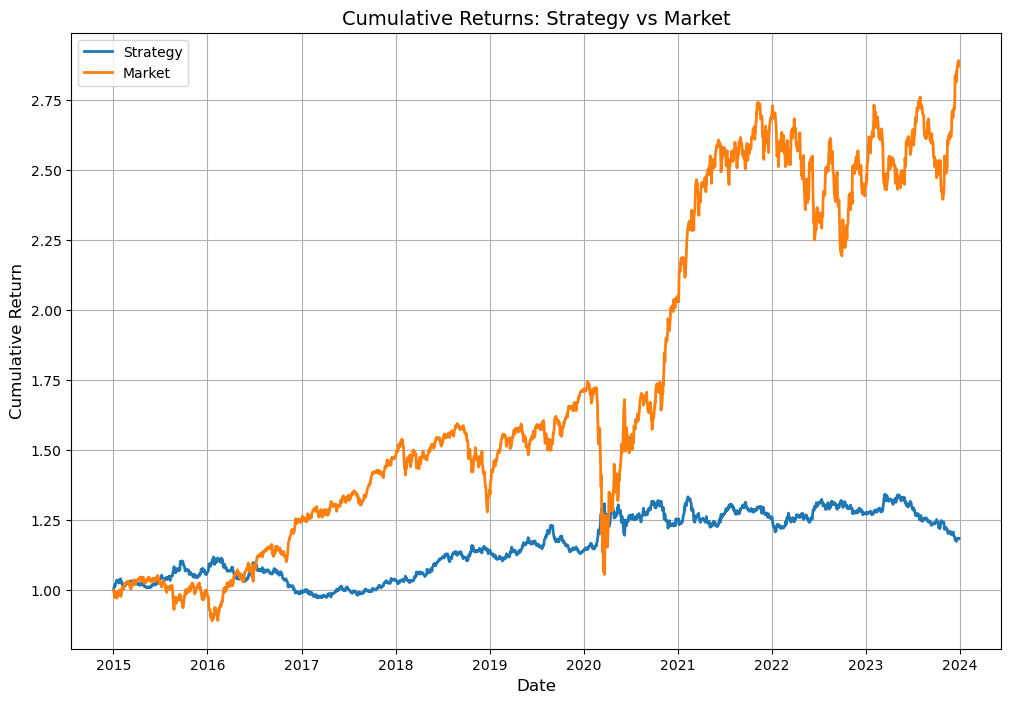


Analyzing PCA Components: K = 8


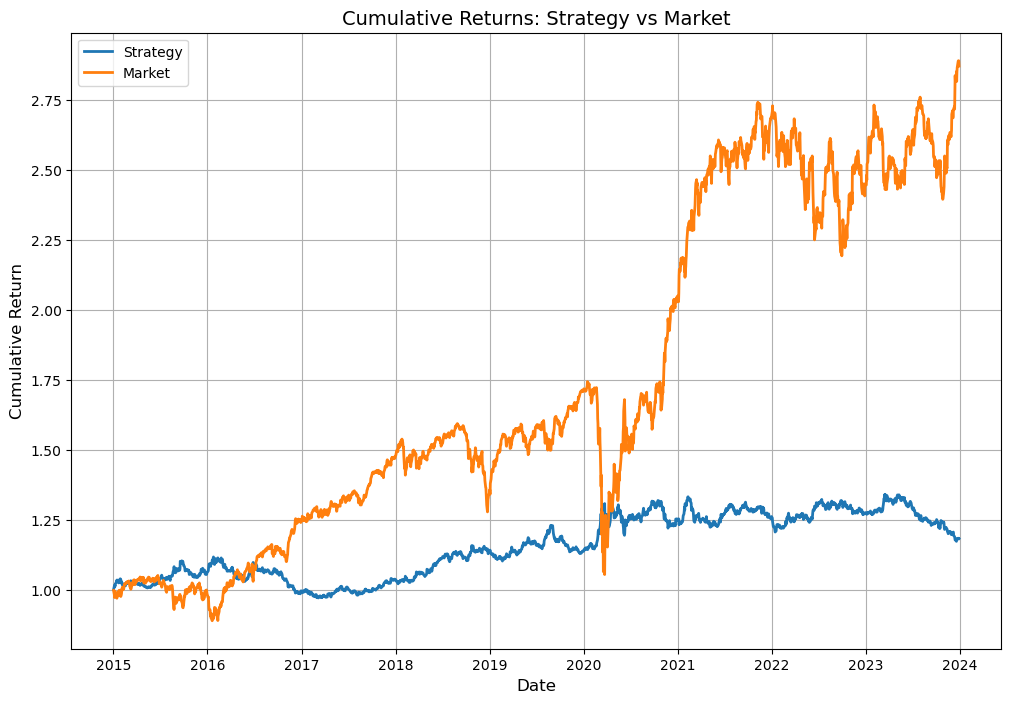


Analyzing PCA Components: K = 9


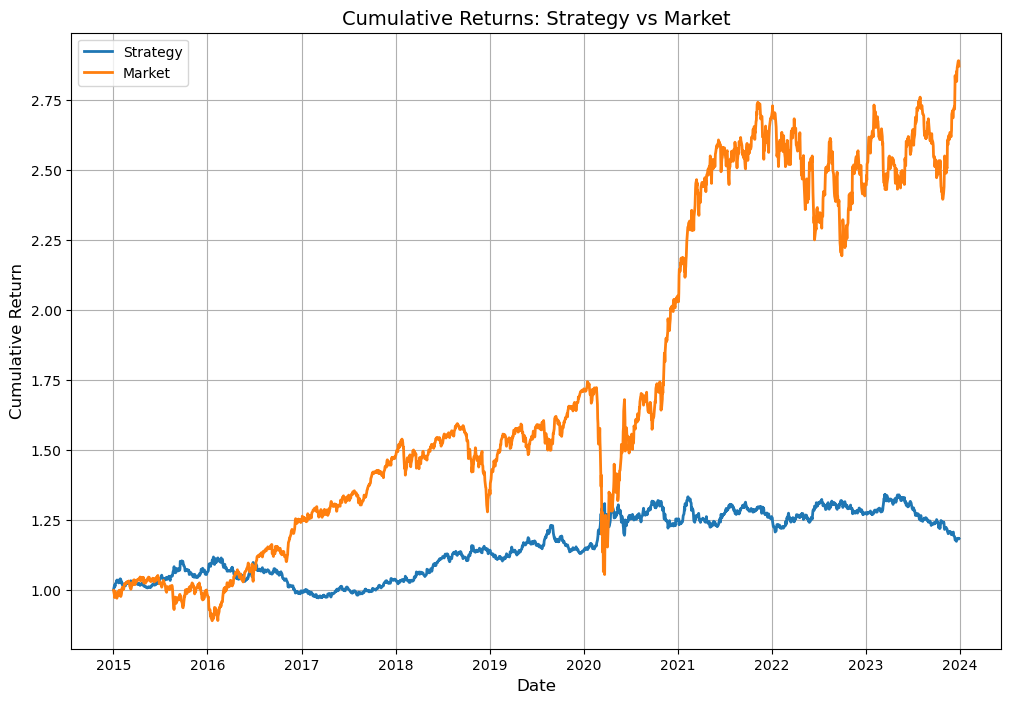


Analyzing PCA Components: K = 10


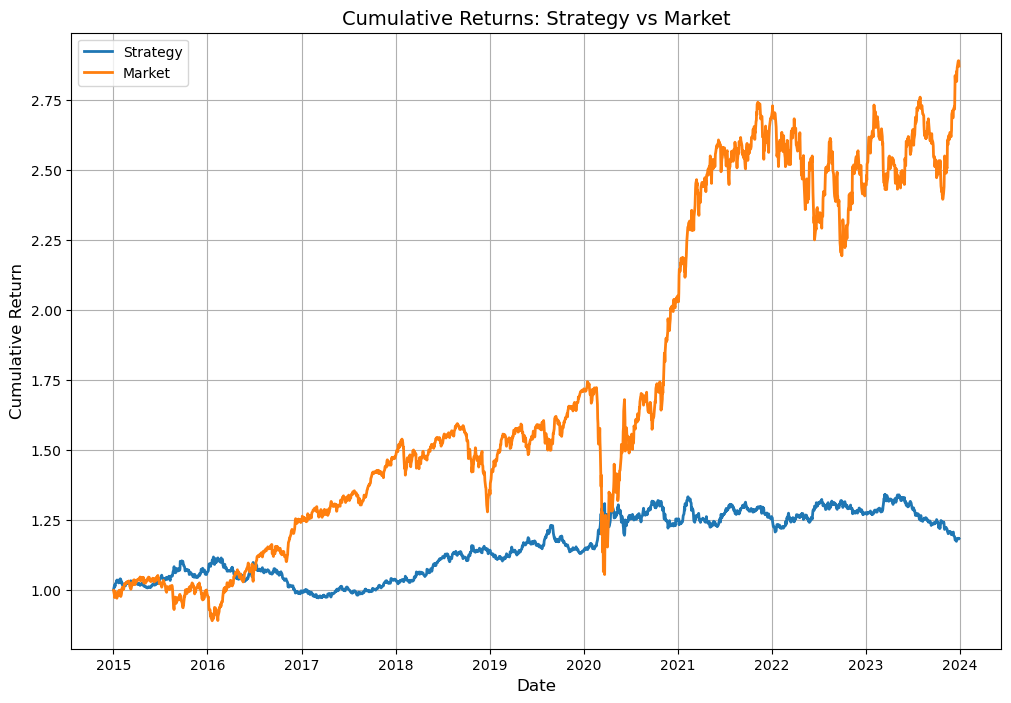

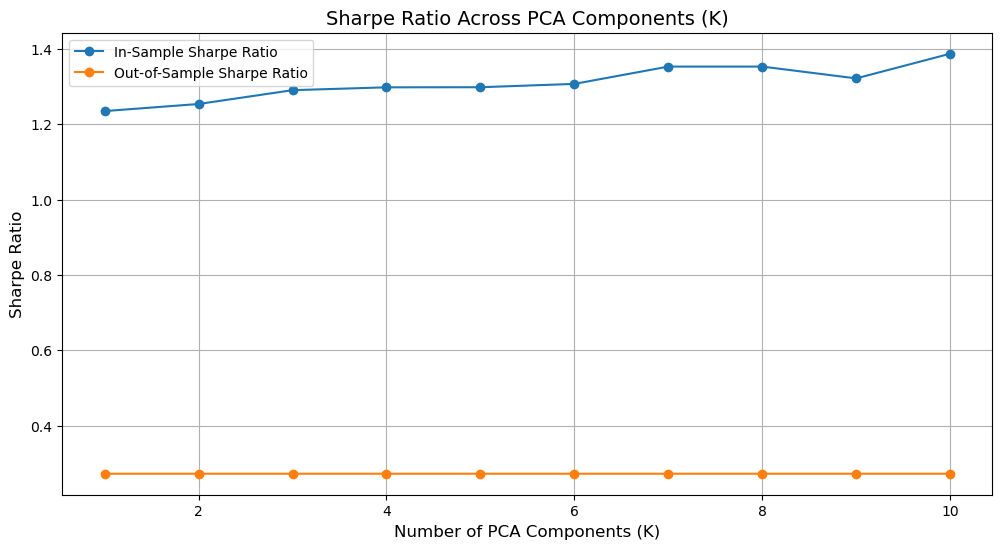

In [ ]:
k_values = list(range(1, 11))  # Test K from 1 to 10, can change to 
# k_values = [1, 3, 5, 7, 10]  # Test specific K values
in_sample_results, out_of_sample_results = analyze_pca_components(data, k_values, start_date='2015-01-01')
plot_results(in_sample_results, out_of_sample_results)